In [1]:
from copy import deepcopy
from statistics import stdev
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def graph_progress(all_costs, all_accuracies, show_recents=True):
    # last 5 results
    # ---------------
    if show_recents:
        line1 = "cost: "
        line2 = "acc:  "
        for i in range(-5, 0):
            line1 += "{:>6} ".format(round(all_costs[i], 3))
            line2 += "{:>6}%".format(round(all_accuracies[i]*100, 2))
        print(line1)
        print(line2)


    # graphs
    # -------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].plot(range(len(all_costs)), all_costs, label="costs")
    axes[0].set_xlabel('step') # Set the y axis label of the current axis.
    axes[0].set_ylabel('cost') # Set a title of the current axes.
    axes[0].set_title('cost over training steps') 
    axes[0].legend() # show a legend on the plot

    axes[1].plot(range(len(all_accuracies)), all_accuracies, label="accuracies")
    axes[1].set_xlabel('step') # Set the y axis label of the current axis.
    axes[1].set_ylabel('accuracy') # Set a title of the current axes.
    axes[1].set_title('accuracy over training steps') 
    axes[1].legend() # show a legend on the plot

    return fig.tight_layout()

# import training data

In [3]:
import pandas as pd #1
import os           #3

In [4]:
given_data_folder = 'prepped'

file_names = os.listdir(given_data_folder)
file_names.sort()
file_names

['.DS_Store',
 'M_predictions.csv',
 'M_testing.csv',
 'M_training_data.csv',
 'W_predictions.csv',
 'W_testing.csv',
 'W_training_data.csv',
 'predictions']

In [5]:
training_data_file = 'M_training_data.csv'

In [6]:
file_path = given_data_folder + '/' + training_data_file 
training_df  = pd.read_csv(file_path)
print(len(training_df))

training_df.head(5)

46338


,Pts,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,...,xFTA_a,xOR_a,xDR_a,xAst_a,xTO_a,xStl_a,xBlk_a,xPF_a,xStr_a,solution
0,0.750000,0.633800,0.787037,0.439078,0.680556,0.750842,0.662162,0.605263,0.851351,0.645833,...,-0.567568,-0.605263,-0.675676,-0.479167,-0.659091,-0.538462,-0.500000,-0.621212,-0.847291,1
1,0.754902,0.658602,0.555556,0.582219,0.930556,0.601307,0.594595,0.578947,0.783784,0.645833,...,-0.675676,-0.578947,-0.770270,-0.354167,-0.659091,-0.807692,-0.375000,-0.606061,-0.400841,-1
2,0.833333,0.763211,0.648148,0.694010,0.555556,0.798333,0.662162,0.236842,0.810811,0.791667,...,-0.567568,-0.657895,-0.635135,-0.687500,-0.454545,-0.615385,-0.500000,-0.606061,-0.768758,1
3,0.699346,0.750538,0.629630,0.404228,0.712963,0.706472,0.513513,0.280702,0.684685,0.625000,...,-0.675676,-0.543860,-0.702703,-0.569444,-0.666667,-0.615385,-0.458333,-0.545455,-0.541014,-1
4,0.700980,0.737634,0.750000,0.435882,0.583333,0.632353,0.391892,0.684211,0.716216,0.708333,...,-0.297297,-0.394737,-0.567568,-0.312500,-0.863636,-0.538462,-0.562500,-0.439394,-0.598615,1


## get as rows

In [9]:
# wether or not to keep the data for stats against a team
keep_against = True

In [10]:
training_column_names = training_df.columns.tolist()

# get all data as columns
training_columns = []
for i in range(len(training_column_names)):
    new_column = list(training_df[training_column_names[i]])
    training_columns.append(new_column)

    
    
# indicis
# 30 each 0:15, 15:30, 30:45, 45:60
if not keep_against:
    new_training_columns = training_columns[0:15] + training_columns[30:45] + [training_columns[60]]
    training_columns = new_training_columns


    
# get as rows
training_input_rows    = []
training_solution_rows = []
for i in range(len(training_columns[0])):
    new_input_row    = []
    new_solution_row = [training_columns[-1][i]]
    for j in range(len(training_columns)-1):
        new_input_row.append(training_columns[j][i])
        
    training_input_rows   .append(new_input_row)
    training_solution_rows.append(new_solution_row)
    
print(len(training_input_rows), len(training_input_rows[0]))
print(len(training_solution_rows), len(training_solution_rows[0]))

46338 122
46338 1


In [11]:
#split = 14000
#np_inputs    = np.array(training_input_rows[:split])
#np_solutions = np.array(training_solution_rows[:split])

np_inputs    = np.array(training_input_rows)
np_solutions = np.array(training_solution_rows)

np_data = [np_inputs, np_solutions]

# Create and Train population

In [12]:
import sys
sys.path.append("../../..")

from network_matrix.population_v3 import Population

### create it here

In [13]:
'''
learning_rate, steps, batch_size,    cost,      acc,
-------------- ------ ----------- -------- ---------
       0.0001,    50,          2,   0.215,   65.51%,
       0.0001,    50,          2,   0.200    68.70%, # 5 recent games, without against
       
''';
num_inputs = len(np_inputs[0])
num_inputs

122

In [14]:
TEST_population  = Population(num_inputs, 1, learning_rate=0.0001)

all_times = [0,0,0,0,0]
all_costs = []
all_accuracies = []

In [24]:
# training loops
# ---------------
#times, costs, accuracies = TEST_population.train_and_test(np_data, 6_000)
times, costs, accuracies = TEST_population.train_and_test_stochastic(np_data, 50, batch_size=2)

# update tracking
# ---------------
for i in range(len(all_times)):
    all_times[i] += times[i]
all_costs      += costs
all_accuracies += accuracies

Training Progress:                             |    cost     acc  |     steps           time      remaining  
                                               | --------  ------ | ----------  -------------  ------------- 


 
               time(s)   percent  per step       | steps:              150
            ----------  --------  --------       | learning rate:   0.0001
calc value    24m 0.7s     27.66%      9.6       | # connections:    90344
grad dscnt   43m 13.7s      49.8%    17.29       | L1 (sum):        0.0003
scoring       3m 37.7s      4.18%     1.45       | L2 (**2):        0.0022
step time    1h 26m 48.1s     100.0%    34.72

cost:  0.191  0.191  0.191  0.191  0.191 
acc:   70.08% 70.07% 70.06% 70.06% 70.05%


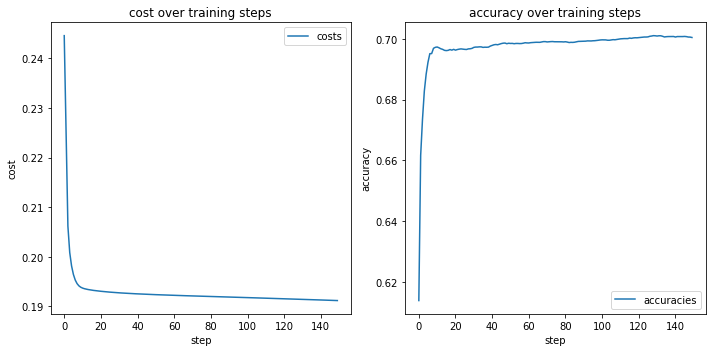

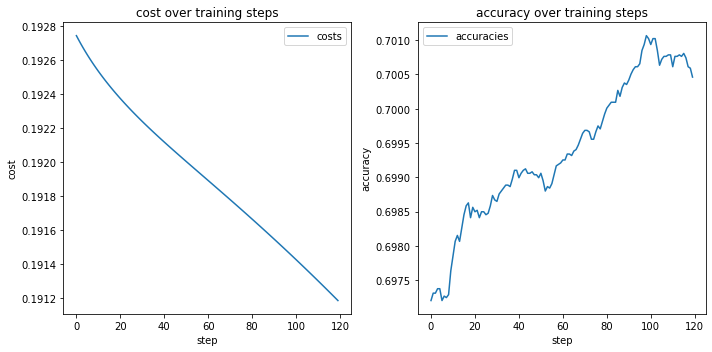

In [23]:
TEST_population.report_training_progress(all_times)     # timing
graph_progress(all_costs, all_accuracies)               # graphs
graph_progress(all_costs[30:], all_accuracies[30:], show_recents=False) # graphs (recent)

In [25]:
TEST_population.print_magnitudes_report()


           abs_avg   abs_med       sum       max       min
          --------  --------  --------  --------  --------
values       0.675     0.735    -2.177     0.999    -0.999
biases       0.062     0.039    -0.782     0.374    -0.371
weights      0.041     0.028     1.431     0.297    -0.347
          --------  --------  --------  --------  --------
values       0.258     0.224    -8.174     0.731    -0.788
biases       0.019     0.012     0.165     0.112    -0.083
weights       0.03      0.02    14.993     0.251    -0.282
          --------  --------  --------  --------  --------
values       0.131      0.11     -1.58     0.411    -0.445
biases        0.01     0.004     0.121      0.07    -0.118
weights       0.03      0.02    11.093     0.248    -0.238
          --------  --------  --------  --------  --------
values       0.223     0.223     0.223     0.223     0.223
biases       0.044     0.044    -0.044    -0.044    -0.044
weights        0.1     0.078     0.162     0.416    -0.

# import testing data

In [26]:
testing_data_file = 'M_testing.csv'

In [27]:
file_path = given_data_folder + '/' + testing_data_file 
testing_df  = pd.read_csv(file_path)
print(len(testing_df))

testing_df.head(5)

617824


,team_1_id,team_2_id,Pts,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,...,xFTM_a,xFTA_a,xOR_a,xDR_a,xAst_a,xTO_a,xStl_a,xBlk_a,xPF_a,xStr_a
0,1101_2017,1102_2017,0.700000,0.715833,0.644444,0.596241,0.572222,0.740946,0.421622,0.410526,...,-0.710842,-0.627027,-0.452632,-0.637838,-0.541667,-0.527273,-0.538462,-0.25,-0.466667,-0.698992
1,1102_2017,1101_2017,0.596078,0.617095,0.548148,0.425862,0.627778,0.713678,0.589189,0.389474,...,-0.753033,-0.421622,-0.421053,-0.767568,-0.733333,-0.563636,-0.523077,-0.30,-0.612121,-0.328371
2,1101_2017,1103_2017,0.700000,0.715833,0.644444,0.596241,0.572222,0.740946,0.421622,0.410526,...,-0.710842,-0.627027,-0.452632,-0.637838,-0.541667,-0.527273,-0.538462,-0.25,-0.466667,-0.698992
3,1103_2017,1101_2017,0.703922,0.812919,0.577778,0.534792,0.694444,0.629716,0.454054,0.547368,...,-0.781170,-0.497297,-0.547368,-0.621622,-0.450000,-0.572727,-0.492308,-0.25,-0.509091,-0.467162
4,1101_2017,1104_2017,0.700000,0.715833,0.644444,0.596241,0.572222,0.740946,0.421622,0.410526,...,-0.710842,-0.627027,-0.452632,-0.637838,-0.541667,-0.527273,-0.538462,-0.25,-0.466667,-0.698992


In [28]:
testing_column_names = testing_df.columns.tolist()

# get all data as columns
testing_columns = []
for i in range(len(testing_column_names)):
    new_column = list(testing_df[testing_column_names[i]])
    testing_columns.append(new_column)
    

    
# indicis
# 30 each 2:17, 17:32, 32:47, 47:62
if not keep_against:
    new_testing_columns = testing_columns[0:2] + testing_columns[2:17] + testing_columns[32:47]
    testing_columns = new_testing_columns


    
# get as rows
testing_input_rows    = []
testing_solution_rows = []
for i in range(len(testing_columns[0])):
    new_input_row    = []
    new_solution_row = [testing_columns[0][i], testing_columns[1][i]]
    for j in range(2, len(testing_columns)):
        new_input_row.append(testing_columns[j][i])
        
    testing_input_rows   .append(new_input_row)
    testing_solution_rows.append(new_solution_row)
    
print(len(testing_input_rows), len(testing_input_rows[0]))
print(len(testing_solution_rows), len(testing_solution_rows[0]))

617824 122
617824 2


In [29]:
testing_inputs = np.array(testing_input_rows)

### testing

In [30]:
#             ID, Pred
# 2017_1101_1102,  0.5

In [31]:
# each matchup has two outputs
output_rows = []

outputs = []
for i in range(len(testing_input_rows)):
    TEST_population.layers[0]["values"] = testing_inputs[i]
    output = TEST_population.calculate_values()
    outputs.append(output[0]) 
    
    if len(outputs) == 2:
        team_1 = testing_solution_rows[i-1][0].split('_') # 1101_2017
        team_2 = testing_solution_rows[i-1][1].split('_') # 1102_2017
        year = team_1[1]
        matchup_ID = "{}_{}_{}".format(year, team_1[0], team_2[0])
        
        output_pred = (outputs[0] + (outputs[1]*-1))/2
        final_pred  = (output_pred+1)/2
        
        
        output_rows.append([matchup_ID, final_pred])
        outputs = []
        
        
    progress = "{:>5}%".format(round( (i/len(testing_input_rows))*100, 2 ))
    print(progress, end="\r")
        
print('\n', len(output_rows))

100.0%
 308912


In [32]:
out_sum = 0
out_avg = 0
abs_sum = 0
abs_avg = 0

for i in range(len(output_rows)):
    out_sum += output_rows[i][1]
    abs_sum += abs(output_rows[i][1])

out_avg = round(out_sum / len(output_rows), 5)
abs_avg = round(abs_sum / len(output_rows), 5)
out_sum = round(out_sum, 5)


print("average: {:>7} | abs average: {:>7} | sum: {:>7}".format(  out_avg, abs_avg, out_sum ))

average: 0.47281 | abs average: 0.47281 | sum: 146055.59669


### create output file

In [33]:
output_headers = ["ID", "Pred"]

In [34]:
# create the final dataframe
predictions_df = pd.DataFrame(output_rows, columns=output_headers)

print(predictions_df.shape)
predictions_df.head()

(308912, 2)


,ID,Pred
0,2017_1101_1102,0.304698
1,2017_1101_1103,0.054563
2,2017_1101_1104,0.029072
3,2017_1101_1105,0.736127
4,2017_1101_1106,0.728175


In [35]:
# to csv
file_name = "prepped/M_predictions.csv"
predictions_df.to_csv(file_name, index=False)